# Gesture Recognition

In this Project, a model for human Hand Gesture Detection is implemented. This note book is divided into following segments:
 - Segment : 1 - Import various Libraries and perform EDA on Data
 - Segment : 2 - Define Data Generator and various Basic Models. Choose the Appropriate Model
 - Segment : 3 - Apply Pre-processing techniques and Run the selected Model
 - Segment : 4 - Tune the Hyper parameters of the model
 - Segment : 5 - Run the Final Model and store the H5 file 

## Segment - 1 - Import various Libraries and perform EDA on Data

In [1]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os
import matplotlib.pyplot as plt
import cv2
import pandas as pd

# Model Building 
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, GRU, Flatten, TimeDistributed, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, Callback, History, EarlyStopping
from keras import optimizers
from keras.regularizers import l2

Using TensorFlow backend.


We set the random seed so that the results don't vary drastically.

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

In [4]:
# Define all the constants
ini_frame=0
num_frames=30
frame_width=120
frame_height=120
num_channels=3
num_classes=5
logging_csv='./training.csv'
train_path = './Project_data/train'
val_path = './Project_data/val'
train_csv='./Project_data/train.csv'
val_csv='./Project_data/val.csv'

# Selecting all the images of given video
img_idx_list=range(ini_frame,num_frames+ini_frame)

pts1 = np.float32([[10,10],[110,10],[10,110],[110,110]])
pts2 = np.float32([[0,0],[120,0],[0,120],[120,120]])

train_doc = np.random.permutation(open(train_csv).readlines())
val_doc = np.random.permutation(open(val_csv).readlines())

### EDA 

In [5]:
train_df=pd.read_csv('./Project_data/train.csv',header=None)
print(train_df.shape)
train_df=train_df[0].str.split(pat=';',expand=True)
print(train_df.shape)
train_df.head(3)

(663, 1)
(663, 3)


,0,1,2
0,WIN_20180925_17_08_43_Pro_Left_Swipe_new,Left_Swipe_new,0
1,WIN_20180925_17_18_28_Pro_Left_Swipe_new,Left_Swipe_new,0
2,WIN_20180925_17_18_56_Pro_Left_Swipe_new,Left_Swipe_new,0


In [6]:
train_df.rename(index=str, columns={0: 'video', 1: "gesture", 2:'label'},inplace=True)
train_df.groupby('label')['video'].count()

label
0    136
1    137
2    130
3    137
4    123
Name: video, dtype: int64

In [7]:
label_0_img=train_df[train_df['label']=='0']['video'][1]
label_1_img=train_df[train_df['label']=='1']['video'][0]
label_2_img=train_df[train_df['label']=='2']['video'][0]
label_3_img=train_df[train_df['label']=='3']['video'][0]
label_4_img=train_df[train_df['label']=='4']['video'][0]

In [8]:
def display_images(lable_image,item=1,source_path='./Project_data/train'):
    
    imgs = os.listdir(source_path+'/'+ lable_image) 
    image = imread(source_path+'/'+ lable_image +'/'+imgs[item])
    
    resized = cv2.resize(image, (120,120), interpolation = cv2.INTER_AREA)
    norm1 = cv2.normalize(resized,None,0,127.5,cv2.NORM_L2)
    norm2 = cv2.normalize(resized,None,0,127.5,cv2.NORM_MINMAX)
    norm3 = resized/127.5-1
    blur_image= cv2.GaussianBlur(resized,(3,3),3)
    
    edg_detc = cv2.Canny(blur_image,80,150)
    edg_detc_1 = cv2.cvtColor(edg_detc,cv2.COLOR_GRAY2RGB)
    edg_detc_2 = cv2.Laplacian(blur_image,cv2.CV_64F)
    
    l, m = np.random.randint(-1.7, 1.8, 2)
    Af = np.float32([[1, 0, l], [0, 1, m]])        
    affn_img=cv2.warpAffine(blur_image, Af,(120, 120))
    
    M = cv2.getPerspectiveTransform(pts1,pts2)
    presp_img=cv2.warpPerspective(blur_image,M,(frame_width,frame_height))
    
    fig=plt.figure(figsize=(20, 32), facecolor='w', edgecolor='k')
    
    plt.subplot(191)
    plt.axis('off')
    plt.title('Original')
    plt.imshow(image)
    
    plt.subplot(192)
    plt.axis('off')
    plt.title('Resized')
    plt.imshow(resized)
    
    plt.subplot(193)
    plt.title('Norm 1')
    plt.axis('off')
    plt.imshow(norm1)
    
    plt.subplot(194)
    plt.title('Norm 2')
    plt.axis('off')
    plt.imshow(norm2)
    
    plt.subplot(195)
    plt.title('Norm 3')
    plt.axis('off')
    plt.imshow(norm3)
    
    plt.subplot(196)
    plt.title('Edge1')
    plt.axis('off')
    plt.imshow(edg_detc_1)
    
    plt.subplot(197)
    plt.title('Edge2')
    plt.axis('off')
    plt.imshow(edg_detc_2)
    
    plt.subplot(198)
    plt.title('Affn')
    plt.axis('off')
    plt.imshow(affn_img)
    
    plt.subplot(199)
    plt.title('Presp')
    plt.axis('off')
    plt.imshow(presp_img)
    
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


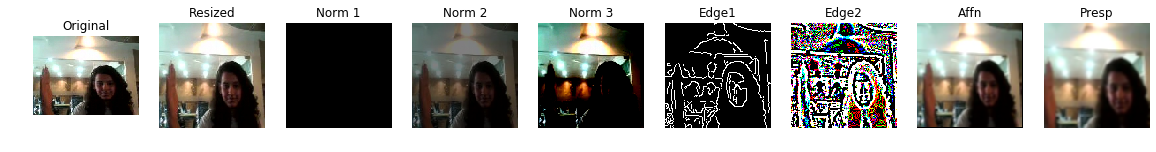

In [9]:
display_images(label_0_img,item=5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


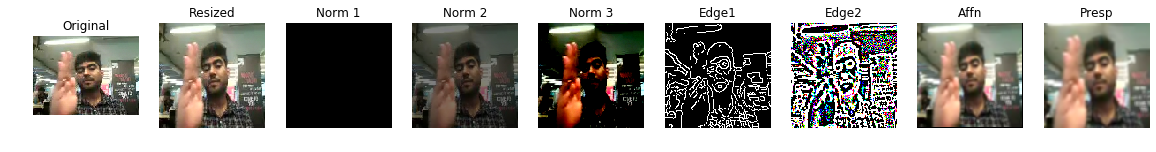

In [10]:
display_images(label_1_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


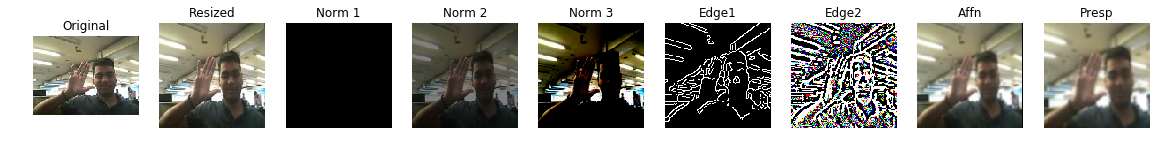

In [11]:
display_images(label_2_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


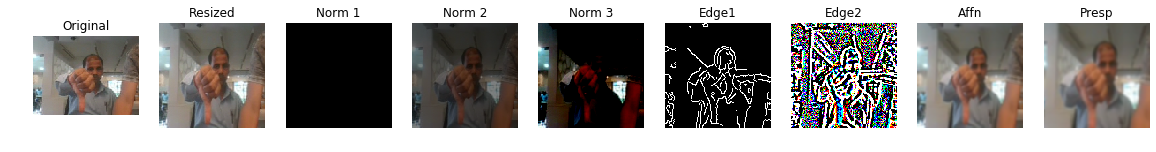

In [12]:
display_images(label_3_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


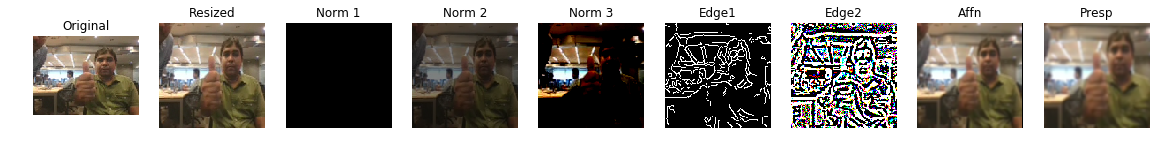

In [13]:
display_images(label_4_img)

(120, 160, 3)


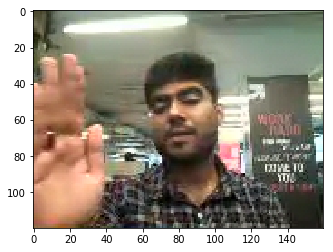

In [14]:
item=0
imgs = os.listdir(train_path+'/'+ label_1_img) 
image = imread(train_path+'/'+ label_1_img +'/'+imgs[item])
print(image.shape)
plt.imshow(image)

(120, 160, 3)


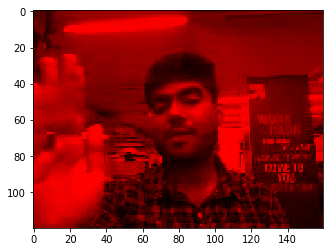

In [15]:
image[:, :, 1] = 0
image[:, :, 2] = 0
print(image.shape)
plt.imshow(image)

### Observations: 
 - CV2 MinMAx Normalisation will be selected as pre-processing technique. Set the min and max as - 0 and 127.5. This technique will normalise the image while skewness is not introduced.
 - Cropping leads to data loss - especially in some images and as such, resize will be done. Resizing maintains the aspect ratio of image
 - Algorithmic learning might drop drastically due to edge detection, as the object that will need to be detection various according to the gesture.
 - Affine, Perspective and Flip Transformations will aid the learning, as additional data points are augmented during training period.

## Segment - 2 - Define Data Generator and Basic Models. Choose the Appropriate Model

### Define a customised generator function : 
 - The generator function applies various pre-processing techniques based on the Flags passed to the function. 
 - When a single channel image processing is requested, the generator function will pick up Red channel 
 - Based on conclusions from previous Segment, the image Resizing, Normalisation ( Min - Max), affine, Perspective and Flip transformations are applied.
 - The Validation accuracy and Validation loss are captured from 'fit_generator' function for model valuation.
 - Define funtion to plot the captured val_acc and val_loss vs Epochs
 - Define funtion to tune the optimiser
 - Define Keras call back option to reduce the learing rate by 0.5( half the learning rate) when a plateau is hit during gradient descent.

In [16]:
def generator(source_path,folder_list,batch_size,crop,normalize,edgdetect,train,affn,persp,flip,Singchannel):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    print('Image Preprocessing options:  ')
    print('Cropping : ',crop)
    print('Normalize: ',normalize)
    print('Edge Detection : ',edgdetect)
    print('Affine Transformation: ', affn)
    print('Mode : ', train)
    print('Perspective Transformation : ', persp)
    print('Flip Transformation : ', flip)
    print('Single Channel : ', Singchannel)
    print('-'*40)
    img_idx = img_idx_list
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(np.floor(len(folder_list)/batch_size))
        for batch in range(num_batches):             
            yield batch_load(source_path,folder_list,batch,batch_size,t,img_idx,
                             crop,normalize,edgdetect,train,affn,persp,flip,Singchannel)
         
        #code for the remaining data points which are left after full batch
        if (len(folder_list) != batch_size*num_batches):
            batch_size = len(folder_list) - (batch_size*num_batches)
            yield batch_load(source_path,folder_list,batch,batch_size,t,img_idx,
                             crop,normalize,edgdetect,train,affn,persp,flip,Singchannel)
            
def batch_load(source_path,folder_list,batch,batch_size,t,img_idx,crop,normalize,edgdetect,train,affn,persp,flip,Singchannel):
    
    batch_data = np.zeros((batch_size,num_frames,frame_height,frame_width,num_channels)) 
    batch_labels = np.zeros((batch_size,5)) 
    batch_data_affn = np.zeros((batch_size,num_frames,frame_height,frame_width,num_channels))
    batch_labels_affn = np.zeros((batch_size,5))
    batch_data_persp = np.zeros((batch_size,num_frames,frame_height,frame_width,num_channels))
    batch_labels_persp = np.zeros((batch_size,5))
    batch_data_flip = np.zeros((batch_size,num_frames,frame_height,frame_width,num_channels))
    batch_labels_flip = np.zeros((batch_size,5))
    
    # iterate over the batch_size
    for folder in range(batch_size): 
                
        # read all the images in the folder
        imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
        # Define a Affine Transformation for image Augmentation
        l, m = np.random.randint(-1.7, 1.8, 2)
        Af = np.float32([[1, 0, l], [0, 1, m]])
        
        #  Iterate over the frames/images of a folder
        for idx,item in enumerate(img_idx):  
            
            image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
           
            # Crop the image
            if crop:     
                if image.shape[0] != image.shape[1]:
                      image=image[0:120,20:140]
                    
            # Resize the Images maintaining the aspect ratio
            temp_image = cv2.resize(image, (120,120), interpolation = cv2.INTER_AREA)        
            
            # Normalize the image
            if normalize:  
                    temp_image = cv2.normalize(temp_image,None,0,127.5,cv2.NORM_MINMAX)
            
            # Single Channel - Select only Red channel
            if Singchannel:
                    temp_image[:, :, 1]==0
                    temp_image[:, :, 2]==0
                    
            # Flip the image
            if flip and train:
                   batch_data_flip[folder,idx]=np.flip(temp_image,1)
            
            # Detect Edge 
            if edgdetect[0]:             
                temp_image= cv2.GaussianBlur(temp_image,(3,3),3)     
                temp_image=np.uint8(temp_image)
                if edgdetect[1]=='1':                               
                    temp_image = cv2.Canny(temp_image,80,150)
                    temp_image = cv2.cvtColor(temp_image,cv2.COLOR_GRAY2RGB)
                if edgdetect[1]=='2':
                    temp_image=cv2.Laplacian(temp_image,cv2.CV_64F)
                        
            batch_data[folder,idx]=(temp_image)
                    
            # Affine Transformation
            if affn and train: 
                batch_data_affn[folder,idx] = (cv2.warpAffine(temp_image, Af,(120, 120)))
            
            # Perception Transformation
            if persp and train:
                M = cv2.getPerspectiveTransform(pts1,pts2)
                persp_image = cv2.warpPerspective(temp_image,M,(frame_width,frame_height))
                batch_data_persp[folder,idx] = (persp_image)

        batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
        
        # Set up the required labels 
        if flip and train:
                if int(t[folder + (batch*batch_size)].strip().split(';')[2])==0:
                    batch_labels_flip[folder, 1] = 1
                elif int(t[folder + (batch*batch_size)].strip().split(';')[2])==1:
                    batch_labels_flip[folder, 0] = 1
                else:
                    batch_labels_flip[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
        
        if affn and train:
            batch_labels_affn[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
        if persp and train:
            batch_labels_persp[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
               
    
    # Set up full batch data 
    if affn and train:
        batch_labels=np.append(batch_labels, batch_labels_affn, axis = 0)
        batch_data=np.append(batch_data, batch_data_affn, axis = 0)
    
    if persp and train:
        batch_labels=np.append(batch_labels, batch_labels_persp, axis = 0)
        batch_data=np.append(batch_data, batch_data_persp, axis = 0)
        
    if flip and train:
        batch_labels=np.append(batch_labels, batch_labels_flip, axis = 0)
        batch_data=np.append(batch_data, batch_data_flip, axis = 0)
        
    return batch_data, batch_labels 

def optimisation(model,optimise='sgd',decay=False,summary=True,lr_rate=0.01):
    if optimise=='sgd':
        optimiser_method='SGD'
        if decay:
            optimiser = optimizers.SGD(lr=lr_rate,decay=1e-6) 
        else: 
            optimiser = optimizers.SGD()
    else:
        optimiser_method='ADAM'
        if decay:
            optimiser = optimizers.Adam(lr=lr_rate,decay=1e-6)
        else:  
            optimiser = optimizers.Adam()         
        
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    if summary:
        print(model.summary())
    print('Model optimiser is :', optimiser_method)
    print('Optimiser Decay is :', decay)
    print('Running with Learning Rate :', decay)
    
    return model

def init_data_collector():
    global plot_data_df
    plot_data_df = pd.DataFrame()
    

def train_func(size_of_batch,model,model_name,num_epochs,crop=False,normalize=[False,0],edgdetect=[False,0],train=True,affn=False,persp=False,flip=False,Singchannel=False):
    train_generator = generator(train_path,train_doc,size_of_batch,crop,normalize,edgdetect,train,affn,persp,flip,Singchannel)
    dummy_var=False
    val_generator = generator(val_path, val_doc, size_of_batch,crop,normalize,edgdetect,dummy_var,dummy_var,dummy_var,dummy_var,Singchannel)
    num_train_sequences = len(train_doc)
    num_val_sequences = len(val_doc)
    if (num_train_sequences%size_of_batch) == 0:
        steps_per_epoch = int(num_train_sequences/size_of_batch)
    else:
        steps_per_epoch = (num_train_sequences//size_of_batch) + 1

    if (num_val_sequences%size_of_batch) == 0:
        validation_steps = int(num_val_sequences/size_of_batch)
    else:
        validation_steps = (num_val_sequences//size_of_batch) + 1

    # Run the model
    history_obj=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
    
    plot_data_df[model_name+'_val_accuracy']=history_obj.history['val_categorical_accuracy']
    plot_data_df[model_name+'_val_loss']=history_obj.history['val_loss']
    
    
    return history_obj

def plot_data_collector(fig_name):
    fig=plt.figure(figsize=(16, 18), dpi=70, facecolor='w', edgecolor='k')
    plt.subplot(211)
    plt.plot(plot_data_df.filter(regex='_val_accuracy'))
    plt.title('Epochs Vs VAL_ACCU')
    plt.legend(list(plot_data_df.filter(regex='_val_accuracy')),loc='center left', bbox_to_anchor=(1, 0.5))
    plt.subplot(212)
    plt.plot(plot_data_df.filter(regex='_val_loss'))
    plt.title('Epochs Vs VAL_Loss')
    plt.legend(list(plot_data_df.filter(regex='_val_loss')),loc='center left', bbox_to_anchor=(1, 0.5))
    fig.savefig(fig_name)
    plt.show()
    
# Define a Keras Call back function to reduce learning rate when a plateau is hit
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=2, verbose=1)
callbacks_list=[LR]

### Define Various Base Models

In [17]:
# model_1 is Conv3D based model with batch Optimisation and Drop Outs
# model_2 is Conv2D + LSTM
# model_3 is Conv2D + GRU

def model_1(filters_size=[8,16,32,64],dense_size=[256,128],actv_func='relu'):

    input_shape=(num_frames,frame_height,frame_width,num_channels)
   
    model = Sequential()
    model.add(Conv3D(filters_size[0],(3,3,3),activation=actv_func, input_shape=input_shape,padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2,2,2)))

    model.add(Conv3D(filters_size[1],(3,3,3), activation=actv_func,padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2,2,2)))
    
    model.add(Conv3D(filters_size[2],(3,3,3), activation=actv_func,padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2,2,2)))
    
    model.add(Conv3D(filters_size[3],(3,3,3),activation=actv_func,padding='same'))
    model.add(MaxPooling3D(pool_size=(2,2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(dense_size[0], activation=actv_func))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(dense_size[1], activation=actv_func))
    model.add(Dropout(0.25))
    
    model.add(Dense(5, activation='softmax'))
    
    return model

def model_2(filters_size=[8,16,32,64],dense_size=[512,256,128,64],actv_func='relu'):
    
    input_shape=(num_frames,frame_height,frame_width,num_channels)
    
    model = Sequential()
    model.add(TimeDistributed(Conv2D(filters_size[0],(3, 3), activation=actv_func), input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(TimeDistributed(MaxPooling2D()))
    model.add(Dropout(0.25))
    
    model.add(TimeDistributed(Conv2D(filters_size[1],(3, 3),activation=actv_func)))
    model.add(TimeDistributed(Conv2D(filters_size[1], 3, 3,activation=actv_func)))
    model.add(BatchNormalization())
    model.add(TimeDistributed(MaxPooling2D()))
    model.add(Dropout(0.25))
    
    model.add(TimeDistributed(Conv2D(filters_size[2],(3, 3),activation=actv_func,border_mode='valid')))
    model.add(TimeDistributed(Conv2D(filters_size[2],(3, 3),activation=actv_func,border_mode='valid')))
    model.add(BatchNormalization())
    model.add(TimeDistributed(MaxPooling2D()))
    model.add(Dropout(0.5))
    
    model.add(TimeDistributed(Flatten()))
    
    model.add(LSTM(dense_size[1], return_sequences=True))
    model.add(Flatten())
    model.add(BatchNormalization())
    
    model.add(Dense(dense_size[3]))
    model.add(Dropout(0.25))
    
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

def model_3(filters_size=[8,16,32,64],dense_size=[512,256,128,64],actv_func='relu'):
    
    input_shape=(num_frames,frame_height,frame_width,num_channels)
    
    model = Sequential()
    model.add(TimeDistributed(Conv2D(filters_size[0],(3, 3), activation=actv_func), input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(TimeDistributed(MaxPooling2D()))
    model.add(Dropout(0.25))
    
    model.add(TimeDistributed(Conv2D(filters_size[1],(3, 3),activation=actv_func)))
    model.add(TimeDistributed(Conv2D(filters_size[1], 3, 3,activation=actv_func)))
    model.add(BatchNormalization())
    model.add(TimeDistributed(MaxPooling2D()))
    model.add(Dropout(0.25))
    
    model.add(TimeDistributed(Conv2D(filters_size[2],(3, 3),activation=actv_func,border_mode='valid')))
    model.add(TimeDistributed(Conv2D(filters_size[2],(3, 3),activation=actv_func,border_mode='valid')))
    model.add(BatchNormalization())
    model.add(TimeDistributed(MaxPooling2D()))
    model.add(Dropout(0.5))
    
    model.add(TimeDistributed(Flatten()))
    
    model.add(GRU(dense_size[1], return_sequences=True))
    model.add(Flatten())
    model.add(BatchNormalization())
    
    model.add(Dense(dense_size[3]))
    model.add(Dropout(0.25))
    
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

### Test the Generator Function

In [29]:
# Test the Generator function with 'ALL' switches ON. The traning data will be 4 fold - so, 663x4. 
# Batch size set to 100. So, 6 Full batches with each batch holding 400 images and one last batch holding 63x4 images.
batch_size = 100 
train_generator = generator(train_path, train_doc,batch_size,
                            crop=True,normalize=[True,1],edgdetect=[True,1],train=True,affn=True,persp=True,flip=True,Singchannel=True)
for item in range(7):
    bat_data,bat_labl=next(train_generator)
    print('Batch Shape: ',bat_data.shape)

Source path =  ./Project_data/train ; batch size = 100
Image Preprocessing options:  
Cropping :  True
Normalize:  [True, 1]
Edge Detection :  [True, 1]
Affine Transformation:  True
Mode :  True
Perspective Transformation :  True
Flip Transformation :  True
Single Channel :  True
----------------------------------------
Batch Shape:  (400, 30, 120, 120, 3)
Batch Shape:  (400, 30, 120, 120, 3)
Batch Shape:  (400, 30, 120, 120, 3)
Batch Shape:  (400, 30, 120, 120, 3)
Batch Shape:  (400, 30, 120, 120, 3)
Batch Shape:  (400, 30, 120, 120, 3)
Batch Shape:  (252, 30, 120, 120, 3)


### Run the basic models without applying any pre-processing 

In [30]:
init_data_collector()

In [31]:
size_of_batch=10
num_epochs=6
crop=False
normalize=False
edgdetect=[False,0]
affn=False
persp=False
flip=False
train=True
Singchannel=False
model_name='CONV_3D_BN_DO'

model=model_1()
model=optimisation(model)
train_func(size_of_batch,model,model_name,num_epochs,crop,normalize,edgdetect,train,affn,persp,flip,Singchannel)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 120, 120, 8)   32        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 60, 60, 16)    64        
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 7, 30, 30, 16)     0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 7, 30, 30, 32)     13856     
__________

In [32]:
size_of_batch=10
num_epochs=6
crop=False
normalize=False
edgdetect=[False,0]
affn=False
persp=False
flip=False
train=True
Singchannel=False
model_name='LSTM_model'

model=model_2()
model=optimisation(model)
train_func(size_of_batch,model,model_name,num_epochs,crop,normalize,edgdetect,train,affn,persp,flip,Singchannel)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 30, 118, 118, 8)   224       
_________________________________________________________________
batch_normalization_5 (Batch (None, 30, 118, 118, 8)   32        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 59, 59, 8)     0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 30, 59, 59, 8)     0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 57, 57, 16)    1168      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 30, 55, 55, 16)    2320      
_________________________________________________________________
batch_normalization_6 (Batch (None, 30, 55, 55, 16)    64        
__________

In [33]:
size_of_batch=10
num_epochs=6
crop=False
normalize=False
edgdetect=[False,0]
affn=False
persp=False
flip=False
train=True
Singchannel=False
model_name='GRU_model'

model=model_3()
model=optimisation(model)
train_func(size_of_batch,model,model_name,num_epochs,crop,normalize,edgdetect,train,affn,persp,flip,Singchannel)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_10 (TimeDis (None, 30, 118, 118, 8)   224       
_________________________________________________________________
batch_normalization_9 (Batch (None, 30, 118, 118, 8)   32        
_________________________________________________________________
time_distributed_11 (TimeDis (None, 30, 59, 59, 8)     0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 30, 59, 59, 8)     0         
_________________________________________________________________
time_distributed_12 (TimeDis (None, 30, 57, 57, 16)    1168      
_________________________________________________________________
time_distributed_13 (TimeDis (None, 30, 55, 55, 16)    2320      
_________________________________________________________________
batch_normalization_10 (Batc (None, 30, 55, 55, 16)    64        
__________

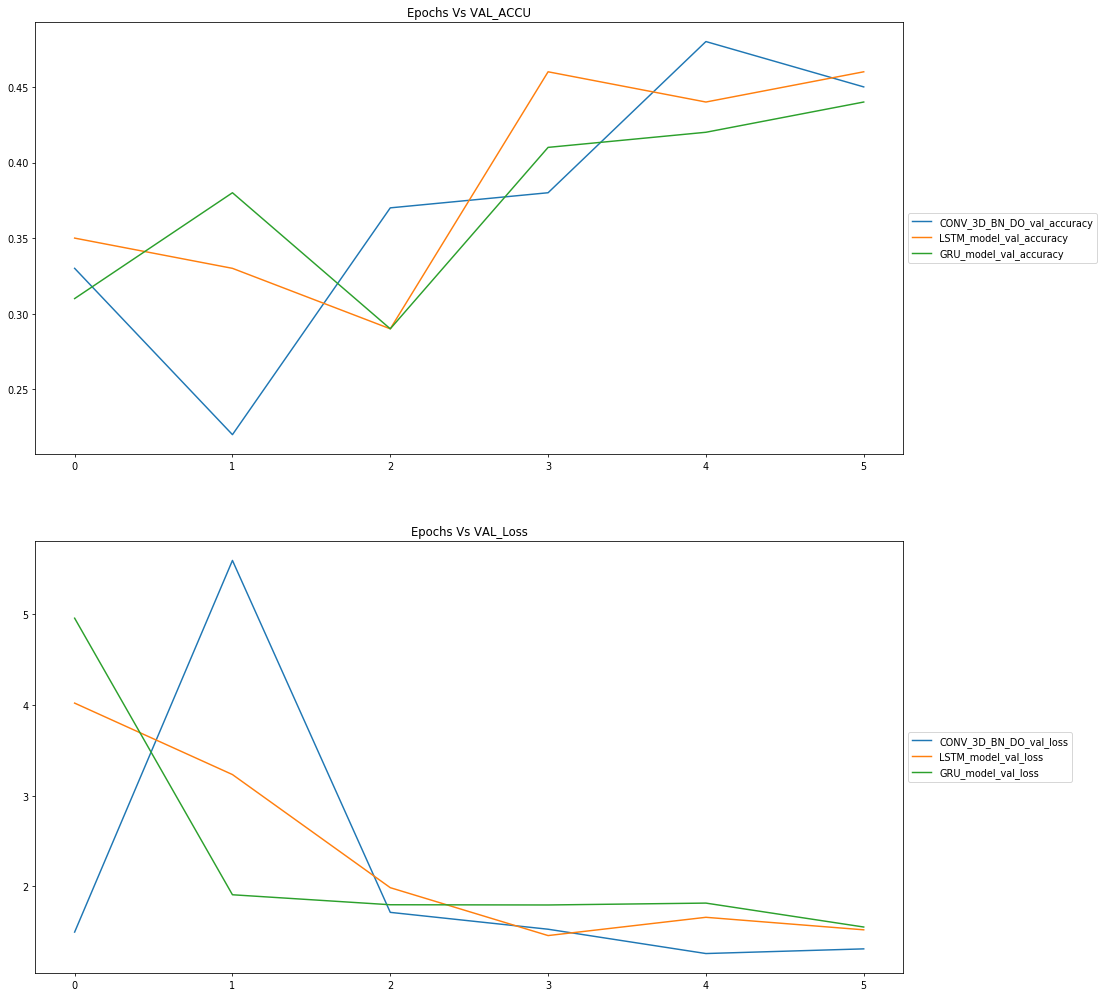

In [34]:
plot_data_collector('Base_model_selection.png')

### Observations:
 - CONV3D model outperforms the LSTM and GRU model interms of learning.
 - CONV3D model has least set of weights and hence better learning can be achieved and is also very economical for training.
 - GRU model has higher loss compared to the LSTM.  However, over the number of epochs, there is subtle difference between the two.

Based on these observations, CONV3D model will be selected for further processing.

## Segment : 3 - Apply Pre-processing techniques and Run the selected Model

In [35]:
# Initialise the dataframe
init_data_collector()

In [36]:
size_of_batch=10
num_epochs=6
crop=False
normalize=True
edgdetect=[False,0]
affn=False
persp=False
flip=False
train=True
model_name='norm'

model=model_1()
model=optimisation(model)
train_func(size_of_batch,model,model_name,num_epochs,crop,normalize,edgdetect,train,affn,persp,flip)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 30, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_13 (Batc (None, 30, 120, 120, 8)   32        
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
batch_normalization_14 (Batc (None, 15, 60, 60, 16)    64        
_________________________________________________________________
max_pooling3d_6 (MaxPooling3 (None, 7, 30, 30, 16)     0         
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 7, 30, 30, 32)     13856     
__________

In [37]:
size_of_batch=10
num_epochs=6
crop=False
normalize=True
edgdetect=[False,0]
affn=True
persp=False
flip=False
train=True

model_name='norm_affn'

model=model_1()
model=optimisation(model)
train_func(size_of_batch,model,model_name,num_epochs,crop,normalize,edgdetect,train,affn,persp,flip)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_9 (Conv3D)            (None, 30, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_17 (Batc (None, 30, 120, 120, 8)   32        
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
batch_normalization_18 (Batc (None, 15, 60, 60, 16)    64        
_________________________________________________________________
max_pooling3d_10 (MaxPooling (None, 7, 30, 30, 16)     0         
_________________________________________________________________
conv3d_11 (Conv3D)           (None, 7, 30, 30, 32)     13856     
__________

In [38]:
size_of_batch=10
num_epochs=6
crop=False
normalize=True
edgdetect=[False,0]
affn=True
persp=True
flip=False
train=True

model_name='norm_affn_presp'

model=model_1()
model=optimisation(model)
train_func(size_of_batch,model,model_name,num_epochs,crop,normalize,edgdetect,train,affn,persp,flip)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_13 (Conv3D)           (None, 30, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_21 (Batc (None, 30, 120, 120, 8)   32        
_________________________________________________________________
max_pooling3d_13 (MaxPooling (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
batch_normalization_22 (Batc (None, 15, 60, 60, 16)    64        
_________________________________________________________________
max_pooling3d_14 (MaxPooling (None, 7, 30, 30, 16)     0         
_________________________________________________________________
conv3d_15 (Conv3D)           (None, 7, 30, 30, 32)     13856     
__________

In [39]:
size_of_batch=10
num_epochs=6
crop=False
normalize=True
edgdetect=[False,0]
affn=True
persp=True
flip=True
train=True

model_name='norm_affn_presp_flip'

model=model_1()
model=optimisation(model)
train_func(size_of_batch,model,model_name,num_epochs,crop,normalize,edgdetect,train,affn,persp,flip)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_17 (Conv3D)           (None, 30, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_25 (Batc (None, 30, 120, 120, 8)   32        
_________________________________________________________________
max_pooling3d_17 (MaxPooling (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_18 (Conv3D)           (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
batch_normalization_26 (Batc (None, 15, 60, 60, 16)    64        
_________________________________________________________________
max_pooling3d_18 (MaxPooling (None, 7, 30, 30, 16)     0         
_________________________________________________________________
conv3d_19 (Conv3D)           (None, 7, 30, 30, 32)     13856     
__________

In [40]:
size_of_batch=20
num_epochs=6
crop=False
normalize=[True,2]
edgdetect=[True,2]
affn=True
persp=False
flip=True
train=True

model_name='norm_affn_flip'

model=model_1()
model=optimisation(model)
train_func(size_of_batch,model,model_name,num_epochs,crop,normalize,edgdetect,train,affn,persp,flip)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_21 (Conv3D)           (None, 30, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_29 (Batc (None, 30, 120, 120, 8)   32        
_________________________________________________________________
max_pooling3d_21 (MaxPooling (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_22 (Conv3D)           (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
batch_normalization_30 (Batc (None, 15, 60, 60, 16)    64        
_________________________________________________________________
max_pooling3d_22 (MaxPooling (None, 7, 30, 30, 16)     0         
_________________________________________________________________
conv3d_23 (Conv3D)           (None, 7, 30, 30, 32)     13856     
__________

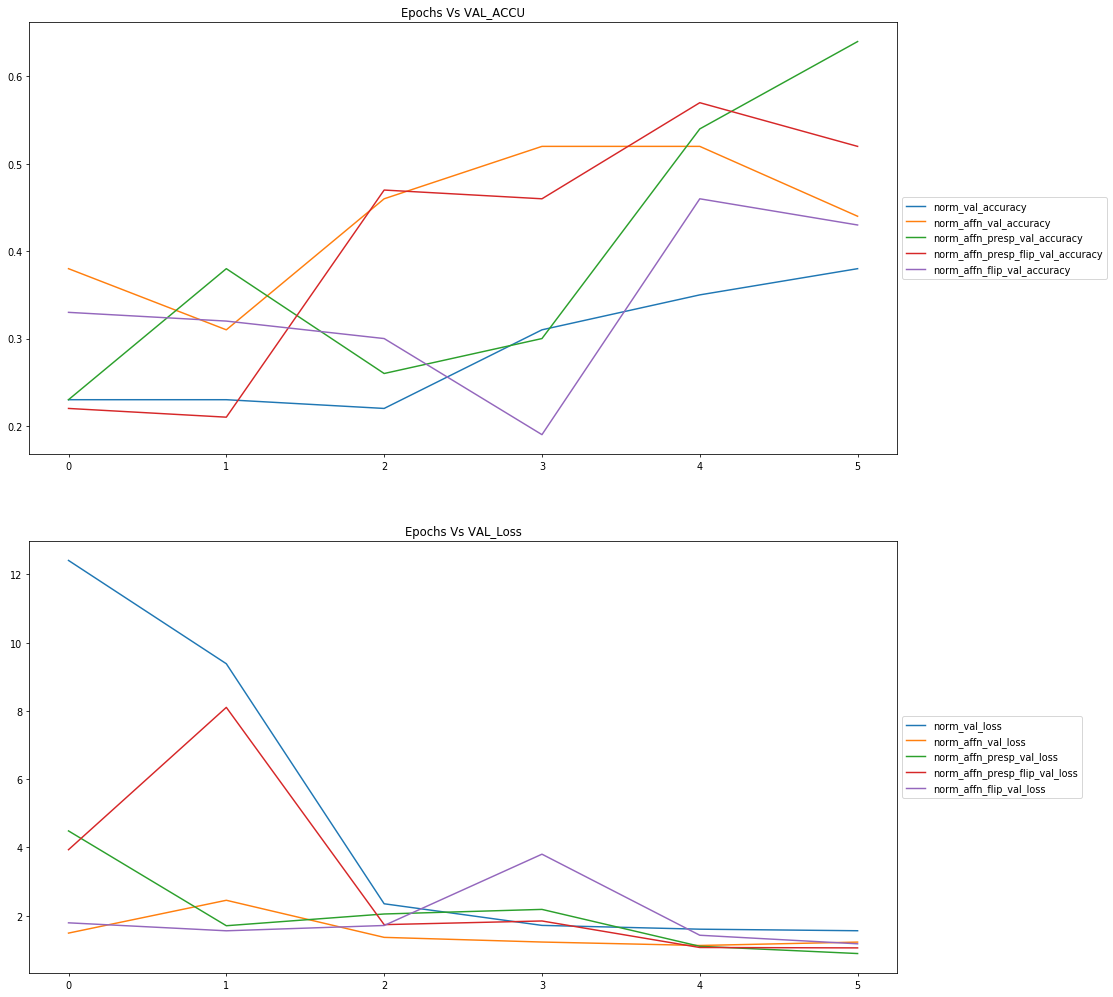

In [41]:
plot_data_collector('select_processing.png')

###  Observations:
 - In this section, various pre-processing techniques have been applies and the model valuation parameters are plotted.
 - From the epochs vs Accuracy curve, it is evident that red line(model with norm_affn_presp_flip) and green line(model with norm_affn_presp) have higher learning rates. The accuracy increased rapidly.
 - These data augmentation techniques have helped the learning.
 - As per the epoch vs Loss curve, the loss in green line is slightly less than that compared to red line. This could be attributed to overfitting in the red line model. The flip technique applied, might potentially be leading to overfitting over number of epochs. 
 - We can apply two of the three augmentation techniques and this can help control the overfitting. 
 - For further processing, select the techniques - normalisation, affine,perspective transformation (model for Green line)


## Segment : 4 - Tune the Hyper parameters of the model

#### Note:
 - In this segment, various hyper parameters for the model will be tuned. 
 - We will start with the optimiser and then the learning rate.
 - Based on the choice of these two parameters, various attributes of model like - kernal size, layers, filters will be experimented. 
 - For each of the experiments, the valuation accuracy and valuation loss will be recorded and model will be evaluated.

### Optimiser

In [42]:
# Initialise the dataframe
init_data_collector()

In [43]:
# Note that above option with best choice ran with SGD with No Decay 
# SGD with Decay option
size_of_batch=10
num_epochs=10
crop=False
normalize=True
edgdetect=[False,2]
affn=True
persp=True
flip=True
train=True

model_name='sgd'

model=model_1()
model=optimisation(model,optimise='sgd',decay=False,summary=False)
train_func(size_of_batch,model,model_name,num_epochs,crop,normalize,edgdetect,train,affn,persp,flip)

Model optimiser is : SGD
Optimiser Decay is : False
Running with Learning Rate : False
Source path = Source path =  ./Project_data/train ; batch size = 10
Image Preprocessing options:  
Cropping :  False
Normalize:  TrueEpoch 1/10
Edge Detection :  [False, 2]
Affine Transformation:  True
Mode :  True
Perspective Transformation :  True
Flip Transformation :  True
Single Channel :  False
----------------------------------------
 ./Project_data/val
 ; batch size = 10
Image Preprocessing options:  
Cropping :  False
Normalize:  True
Edge Detection :  [False, 2]
Affine Transformation:  False
Mode :  False
Perspective Transformation :  False
Flip Transformation :  False
Single Channel :  False
----------------------------------------
67/67 [==============================] - 142s 2s/step - loss: 1.7557 - categorical_accuracy: 0.3082 - val_loss: 1.4156 - val_categorical_accuracy: 0.4300
Epoch 2/10
67/67 [==============================] - 40s 594ms/step - loss: 1.6879 - categorical_accuracy: 0.

In [44]:
# ADAM without Decay 
size_of_batch=10
num_epochs=10
crop=False
normalize=True
edgdetect=[False,0]
affn=True
persp=True
flip=True
train=True

model_name='Adam'

model=model_1()
model=optimisation(model,optimise='adam',decay=False,summary=False)
train_func(size_of_batch,model,model_name,num_epochs,crop,normalize,edgdetect,train,affn,persp,flip)

Model optimiser is : ADAM
Optimiser Decay is : False
Running with Learning Rate : False
Source path =  ./Project_data/val ; batch size = 10
Image Preprocessing options:  
Cropping :  False
Normalize:  True
Edge Detection :  [False, 0]
Affine Transformation:  False
Mode :  False
Perspective Transformation :  False
Flip Transformation :  False
Single Channel :  FalseSource path =  ./Project_data/train ; batch size = 10
Image Preprocessing options:  Epoch 1/10

----------------------------------------

Cropping :  False
Normalize:  True
Edge Detection :  [False, 0]
Affine Transformation:  True
Mode :  True
Perspective Transformation :  True
Flip Transformation :  True
Single Channel :  False
----------------------------------------
67/67 [==============================] - 143s 2s/step - loss: 1.5236 - categorical_accuracy: 0.3949 - val_loss: 1.1200 - val_categorical_accuracy: 0.5300
Epoch 2/10
67/67 [==============================] - 40s 596ms/step - loss: 1.6834 - categorical_accuracy: 0

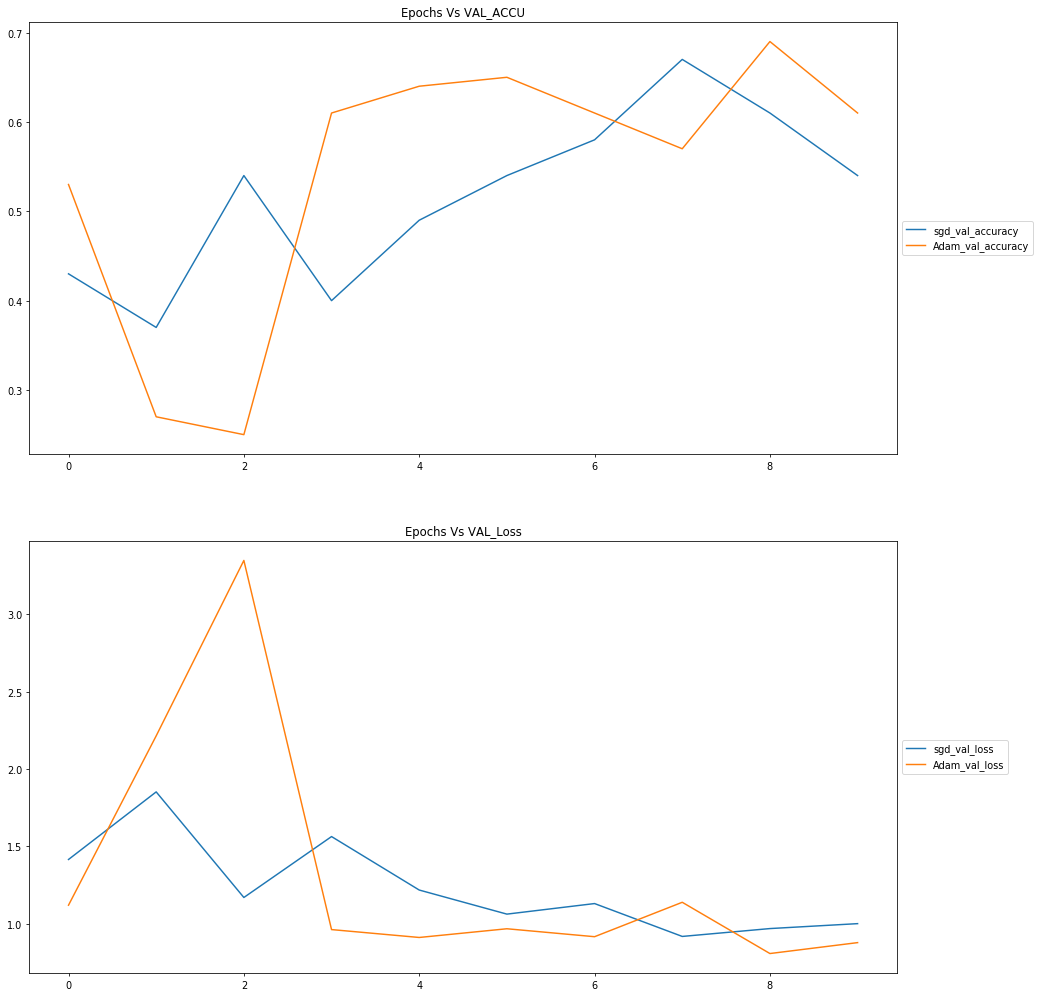

In [45]:
plot_data_collector('Optimiser.png')

### Observations:
 - In this section, two optimisers  - SGD and ADAM are put to test.
 - From the epochs vs loss curve, it is evident that the variations in the loss is higher in case of model where 'ADAM' optimiser is used.  
 - At the end of Epochs, the magnitude of loss is less  in case of model where 'ADAM' optimiser is used.  
 - Thus, we can conclude that model with 'ADAM' optimiser is able to learn faster and better. This Optimiser will be selected for further processing.

### Learning Rate

In [46]:
# Initialise the dataframe
init_data_collector()

In [47]:
# Make the network lean - remove BN where there is DO in CONV 3D layer.
size_of_batch=10
num_epochs=10
crop=False
normalize=True
edgdetect=[False,0]
affn=True
persp=True
flip=True
train=True

model=model_1()

for i in [0.0001,0.001,0.002,0.003,0.005,0.01,0.1]:
    print('='*20+'Model Running for LR = ' + str(i) + '='*20)
    model_name='model_1'+ '_'+str(i)
    model=optimisation(model,optimise='adam',decay=False,summary=False,lr_rate=i)
    train_func(size_of_batch,model,model_name,num_epochs,crop,normalize,edgdetect,train,affn,persp,flip)

====================Model Running for LR = 0.0001====================
Model optimiser is : ADAM
Optimiser Decay is : False
Running with Learning Rate : False
Source path =  Source path =  ./Project_data/train ; batch size = 10
Image Preprocessing options:  
Cropping :  False
Normalize:  True
Edge Detection :  [False, 0]
Affine Transformation:  True
Mode :  True
Perspective Transformation :  True
Flip Transformation :  True
Single Channel :  False
----------------------------------------
Epoch 1/10
./Project_data/val ; batch size = 10
Image Preprocessing options:  
Cropping :  False
Normalize:  True
Edge Detection :  [False, 0]
Affine Transformation:  False
Mode :  False
Perspective Transformation :  False
Flip Transformation :  False
Single Channel :  False
----------------------------------------
67/67 [==============================] - 145s 2s/step - loss: 1.5700 - categorical_accuracy: 0.3630 - val_loss: 1.4655 - val_categorical_accuracy: 0.4300
Epoch 2/10
67/67 [===================

Source path =  ./Project_data/val ; batch size = 10
Image Preprocessing options:  
Cropping :  False
Normalize:  True
Edge Detection :  [False, 0]
Affine Transformation:  False
Mode :  False
Perspective Transformation :  False
Flip Transformation :  False
Single Channel :  False
----------------------------------------
Source path =  ./Project_data/train ; batch size = 10
Image Preprocessing options:  
Cropping :  False
Normalize:  True
Edge Detection :  [False, 0]
Affine Transformation:  True
Mode :  True
Perspective Transformation :  True
Flip Transformation :  True
Single Channel :  False
----------------------------------------
Epoch 1/10
67/67 [==============================] - 142s 2s/step - loss: 0.4465 - categorical_accuracy: 0.8399 - val_loss: 0.8949 - val_categorical_accuracy: 0.6300
Epoch 2/10
67/67 [==============================] - 39s 580ms/step - loss: 0.8117 - categorical_accuracy: 0.7114 - val_loss: 1.4318 - val_categorical_accuracy: 0.5800
Epoch 3/10
67/67 [==========

67/67 [==============================] - 142s 2s/step - loss: 0.1484 - categorical_accuracy: 0.9524 - val_loss: 1.1020 - val_categorical_accuracy: 0.6800
Epoch 2/10
67/67 [==============================] - 39s 580ms/step - loss: 0.3606 - categorical_accuracy: 0.8781 - val_loss: 0.8846 - val_categorical_accuracy: 0.6900
Epoch 3/10
67/67 [==============================] - 40s 595ms/step - loss: 0.4268 - categorical_accuracy: 0.8532 - val_loss: 1.1341 - val_categorical_accuracy: 0.6600
Epoch 4/10
67/67 [==============================] - 42s 632ms/step - loss: 0.3824 - categorical_accuracy: 0.8607 - val_loss: 0.9862 - val_categorical_accuracy: 0.6500

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5/10
67/67 [==============================] - 38s 563ms/step - loss: 0.3209 - categorical_accuracy: 0.9042 - val_loss: 0.7962 - val_categorical_accuracy: 0.7400
Epoch 6/10
67/67 [==============================] - 40s 591ms/step - loss: 0.2644 - categorical_a

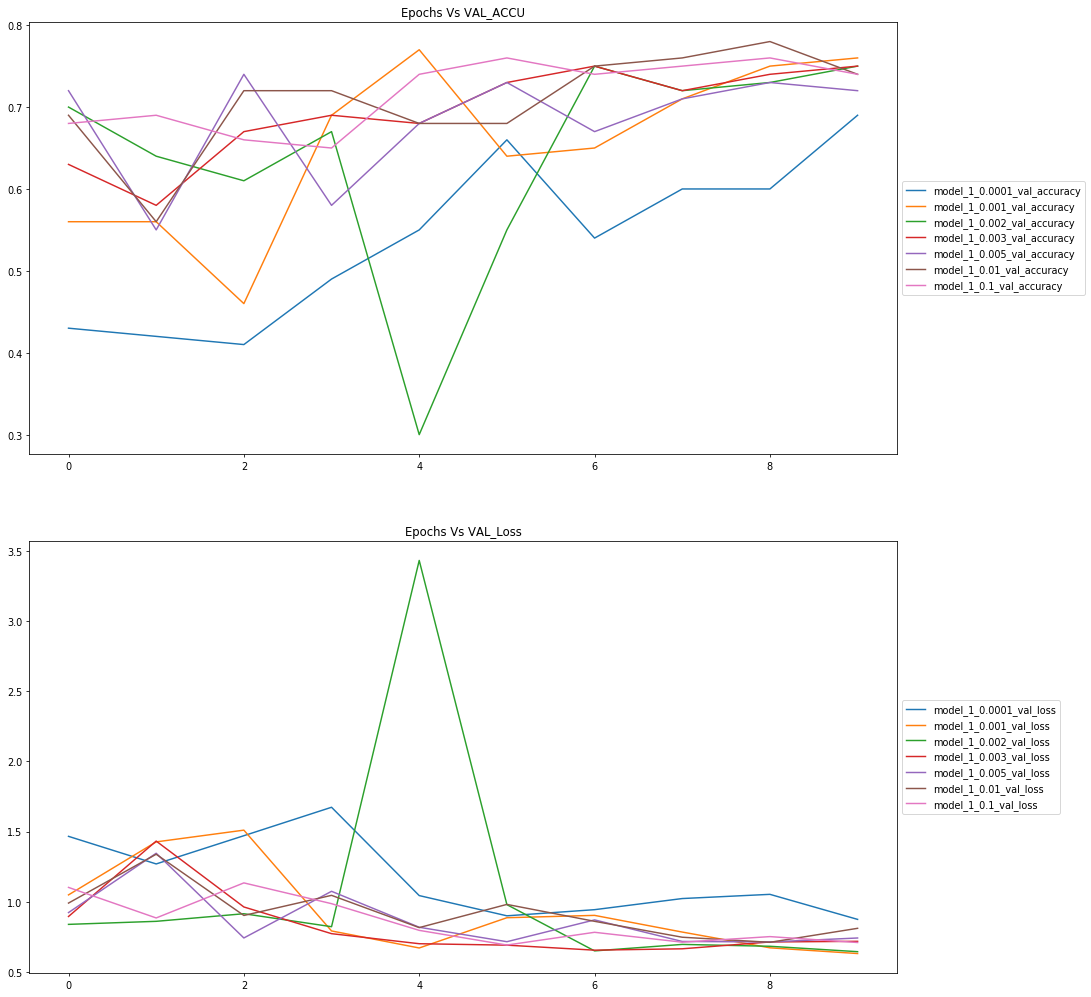

In [48]:
plot_data_collector('learning_rate.png')

### Observations:
 - In this section, the model has been run using various learning rate values.
 - From the epochs vs accuracy curve, the top 4 models are those with learning rates -  0.001,0.002,0.003 and 0.1
 - From the epochs vs loss curve, the top 4 models are those with learning rates -  0.002,0.001,0.003 and 0.1
 - The learning rate 0.1 is too high and often will lead to gradient decent explosion and global minima can never be reached. 
 - The model with 0.002 has a higher loss during epochs 2 and 5. However, loss gradually decreased towards end of epochs.
 - This characteristic of the model implies that the model has effectively learnt during training. 
 - Therefore, the learning rate - 0.002 will be used for further processing.

### Model Network Tuning

### Note:
 - Define various models and run the models by varying number of filters, activation function, size of dense layers.
 - Try various regularization techniques like L2 regularizer, using Batch Optimisation, Drop outs.

In [49]:
best_lr=0.002

In [50]:
# Add Batch Normalisation across all the layers + l2 regularizer in dense layer
def model_1_1(img_channel=3,filters_size=[8,16,32,64],dense_size=[256,128],actv_func='relu'):
  
    input_shape=(num_frames,frame_height,frame_width,num_channels)
   
    model = Sequential()
    model.add(Conv3D(filters_size[0],(3,3,3),activation=actv_func, input_shape=input_shape,padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2,2,2)))

    model.add(Conv3D(filters_size[1],(3,3,3), activation=actv_func,padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2,2,2)))
    
    model.add(Conv3D(filters_size[2],(3,3,3), activation=actv_func,padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2,2,2)))
    
    model.add(Conv3D(filters_size[3],(3,3,3),activation=actv_func,padding='same'))
    model.add(MaxPooling3D(pool_size=(2,2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(dense_size[0], activation=actv_func,kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(dense_size[1], activation=actv_func,kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.25))
    
    model.add(Dense(5, activation='softmax'))
    
    return model

# Increase kernal sizes across the network
def model_1_2(filters_size=[8,16,32,64],dense_size=[256,128],actv_func='relu'):

    input_shape=(num_frames,frame_height,frame_width,num_channels)
   
    model = Sequential()
    model.add(Conv3D(filters_size[0],(5,5,5),activation=actv_func,input_shape=input_shape,padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2,2,2)))

    model.add(Conv3D(filters_size[1],(7,7,7), activation=actv_func,padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2,2,2)))
    
    model.add(Conv3D(filters_size[2],(9,9,9), activation=actv_func,padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2,2,2)))
    
    model.add(Conv3D(filters_size[3],(11,11,11),activation=actv_func,padding='same'))
    model.add(MaxPooling3D(pool_size=(2,2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(dense_size[0], activation=actv_func))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(dense_size[1], activation=actv_func))
    model.add(Dropout(0.25))
    
    model.add(Dense(5, activation='softmax'))
    
    return model

# Add Bottleneck Layers
def model_1_3(filters_size=[8,16,32,64],dense_size=[256,128],actv_func='relu'):

    input_shape=(num_frames,frame_height,frame_width,num_channels)
   
    model = Sequential()
    model.add(Conv3D(filters_size[0],(3,3,3),activation=actv_func, input_shape=input_shape,padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2,2,2)))
    
    model.add(Conv3D(filters_size[1],(3,3,3), activation=actv_func,padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2,2,2)))
    
    model.add(Conv3D(filters_size[2],(3,3,3), activation=actv_func,padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2,2,2)))
    
    model.add(Conv3D(filters_size[2],(1,1,1),activation=actv_func,padding='same'))
    model.add(Conv3D(filters_size[3],(3,3,3),activation=actv_func,padding='same'))
    model.add(MaxPooling3D(pool_size=(2,2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(dense_size[0], activation=actv_func))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(dense_size[1], activation=actv_func))
    model.add(Dropout(0.25))
    
    model.add(Dense(5, activation='softmax'))
    
    return model


In [51]:
# Initialise the dataframe
init_data_collector()

In [52]:
# Change the activation function to sigmoid 
size_of_batch=10
num_epochs=6
crop=False
normalize=True
edgdetect=[False,2]
affn=True
persp=True
flip=True
train=True

model_name='model_1_sigmoid'

model=model_1(actv_func='sigmoid')
model=optimisation(model,optimise='adam',decay=False,summary=False,lr_rate=best_lr)
train_func(size_of_batch,model,model_name,num_epochs,crop,normalize,edgdetect,train,affn,persp,flip)

Model optimiser is : ADAM
Optimiser Decay is : False
Running with Learning Rate : False
Source path =  ./Project_data/val ; batch size = 10
Image Preprocessing options:  
Cropping : Source path =  ./Project_data/train ; batch size = 10
Image Preprocessing options:  
Cropping :   False
False
Normalize:  True
Normalize:  True
Edge Detection :  Edge Detection :  [False, 2]
Affine Transformation:  True
Mode :  True
Perspective Transformation :  True
Flip Transformation :  True
Single Channel :  False
----------------------------------------
[False, 2]
Affine Transformation:  False
Mode :  False
Perspective Transformation :  False
Flip Transformation :  False
Epoch 1/6
Single Channel :  False
----------------------------------------
67/67 [==============================] - 141s 2s/step - loss: 1.5027 - categorical_accuracy: 0.3608 - val_loss: 1.4776 - val_categorical_accuracy: 0.3100
Epoch 2/6
67/67 [==============================] - 39s 581ms/step - loss: 1.5438 - categorical_accuracy: 0.3

In [53]:
# increare the number of Filters
size_of_batch=10
num_epochs=6
crop=False
normalize=True
edgdetect=[False,2]
affn=True
persp=True
flip=True
train=True

model_name='model_1_Filters'

model=model_1(filters_size=[8,16,16,16],dense_size=[256,128])
model=optimisation(model,optimise='adam',decay=False,summary=False,lr_rate=best_lr)
train_func(size_of_batch,model,model_name,num_epochs,crop,normalize,edgdetect,train,affn,persp,flip)

Model optimiser is : ADAM
Optimiser Decay is : False
Running with Learning Rate : False
Source path =  ./Project_data/val ; batch size = 10
Image Preprocessing options:  
Cropping :  False
Normalize:  True
Edge Detection : Source path =  ./Project_data/train ; batch size = 10
Image Preprocessing options:  
Cropping :  False
Normalize:  True
Edge Detection :  [False, 2]
Affine Transformation:  True
Mode :  True
Perspective Transformation :  True
Flip Transformation :  True
Single Channel :  False
----------------------------------------
 [False, 2]
Epoch 1/6Affine Transformation:  False
Mode :  False
Perspective Transformation :  False
Flip Transformation :  False
Single Channel :  False
----------------------------------------

67/67 [==============================] - 142s 2s/step - loss: 1.7192 - categorical_accuracy: 0.3265 - val_loss: 1.3287 - val_categorical_accuracy: 0.3700
Epoch 2/6
67/67 [==============================] - 38s 574ms/step - loss: 1.6485 - categorical_accuracy: 0.3

In [54]:
# Add Batch Normalisation across all the layers + l2 regularizer in dense layer
size_of_batch=20
num_epochs=6
crop=False
normalize=True
edgdetect=[False,2]
affn=True
persp=True
flip=True
train=True

model_name='model_1_1'

model=model_1_1()
model=optimisation(model,optimise='adam',decay=False,summary=False,lr_rate=best_lr)
train_func(size_of_batch,model,model_name,num_epochs,crop,normalize,edgdetect,train,affn,persp,flip)

Model optimiser is : ADAM
Optimiser Decay is : False
Running with Learning Rate : False
Source path =  ./Project_data/val ; batch size = Source path =  Epoch 1/6
./Project_data/train ; batch size =20 20
Image Preprocessing options:  
Cropping : 
Image Preprocessing options:  
Cropping :  False
Normalize:  True
Edge Detection :  [False, 2]
Affine Transformation:  False
Mode :  False
Perspective Transformation :  False
Flip Transformation :  False
Single Channel :  False
----------------------------------------
 False
Normalize:  True
Edge Detection :  [False, 2]
Affine Transformation:  True
Mode :  True
Perspective Transformation :  True
Flip Transformation :  True
Single Channel :  False
----------------------------------------
34/34 [==============================] - 146s 4s/step - loss: 7.4147 - categorical_accuracy: 0.3721 - val_loss: 6.3377 - val_categorical_accuracy: 0.4700
Epoch 2/6
34/34 [==============================] - 19s 561ms/step - loss: 6.3216 - categorical_accuracy: 0.3

In [56]:
# BottleNeck Layer
size_of_batch=10
num_epochs=6
crop=False
normalize=True
edgdetect=[False,2]
affn=True
persp=True
flip=True
train=True

model_name='model_1_3'

model=model_1_3()
model=optimisation(model,optimise='adam',decay=False,summary=False,lr_rate=best_lr)
train_func(size_of_batch,model,model_name,num_epochs,crop,normalize,edgdetect,train,affn,persp,flip)

Model optimiser is : ADAM
Optimiser Decay is : False
Running with Learning Rate : False
Source path =  ./Project_data/val ; batch size = 10
Image Preprocessing options:  
Cropping :  False
Normalize:  True
Edge Detection :  [False, 2]
Affine Transformation:  False
Mode :  False
Perspective Transformation :  False
Flip Transformation :  False
Single Channel :  False
----------------------------------------
Source path =  ./Project_data/train ; batch size = 10
Image Preprocessing options:  
Cropping :  False
Normalize:  True
Edge Detection :  [False, 2]
Affine Transformation:  True
Mode :  True
Perspective Transformation :  True
Flip Transformation :  True
Single Channel :  False
----------------------------------------
Epoch 1/6
67/67 [==============================] - 256s 4s/step - loss: 1.5904 - categorical_accuracy: 0.3550 - val_loss: 1.7321 - val_categorical_accuracy: 0.3700
Epoch 2/6
67/67 [==============================] - 40s 599ms/step - loss: 1.5320 - categorical_accuracy: 0.3

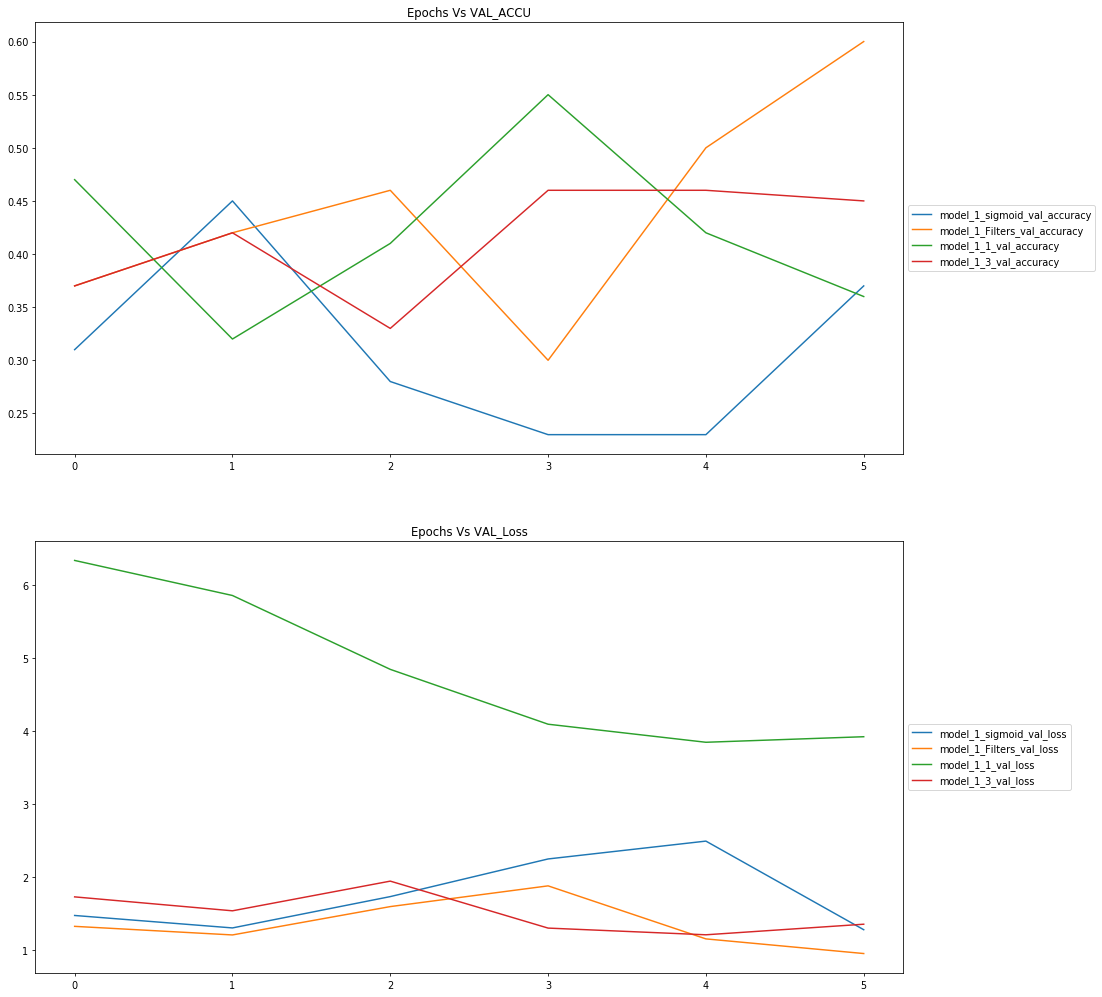

In [57]:
plot_data_collector('Network_Architecture.png')

### Special Note: 
 - Based on the google rearch paper from University of California San Diego published by - Saining Xie, Chen Sun, Jonathan Huang, Zhuowen Tu, Kevin Murphy the convolution of the images will not be applied jointly over time and space(image). 
 - Rather, the convolutions will be applied first on space(image width and height) and then on time. Define a model with the different convolution layers.
 - Ref: https://arxiv.org/abs/1712.04851

In [18]:
# Convolve the images over space( image - height and width) and time over seperate CNN layers
def model_ucsd(filters_size=[8,16,32,64],dense_size=[256,128],actv_func='relu'):

    input_shape=(num_frames,frame_height,frame_width,num_channels)
   
    model = Sequential()
    model.add(Conv3D(filters_size[0],(3,3,3),activation=actv_func, input_shape=input_shape,padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2,2,2)))

    model.add(Conv3D(filters_size[1],(3,3,3), activation=actv_func,padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2,2,2)))
    
    model.add(Conv3D(filters_size[2],(1,3,3), activation=actv_func,padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2,2,2)))
    
    model.add(Conv3D(filters_size[3],(1,3,3),activation=actv_func,padding='same'))
    model.add(Conv3D(filters_size[3],(3,1,1),activation=actv_func,padding='same'))
    model.add(Dropout(0.25))
    model.add(MaxPooling3D(pool_size=(2,2,2)))
    
    model.add(Flatten())

    model.add(Dense(dense_size[0], activation=actv_func))
    model.add(Dropout(0.50))
    
    model.add(Dense(dense_size[1], activation=actv_func))
    model.add(Dropout(0.50))
    
    model.add(Dense(5, activation='softmax'))
    
    return model

In [59]:
# BottleNeck Layer
size_of_batch=10
num_epochs=6
crop=False
normalize=True
edgdetect=[False,2]
affn=True
persp=True
flip=True
train=True

model_name='model_ucsd'

model=model_ucsd()
model=optimisation(model,optimise='adam',decay=False,summary=True,lr_rate=best_lr)
train_func(size_of_batch,model,model_name,num_epochs,crop,normalize,edgdetect,train,affn,persp,flip)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_58 (Conv3D)           (None, 30, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_65 (Batc (None, 30, 120, 120, 8)   32        
_________________________________________________________________
max_pooling3d_57 (MaxPooling (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_59 (Conv3D)           (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
batch_normalization_66 (Batc (None, 15, 60, 60, 16)    64        
_________________________________________________________________
max_pooling3d_58 (MaxPooling (None, 7, 30, 30, 16)     0         
_________________________________________________________________
conv3d_60 (Conv3D)           (None, 7, 30, 30, 32)     4640      
__________

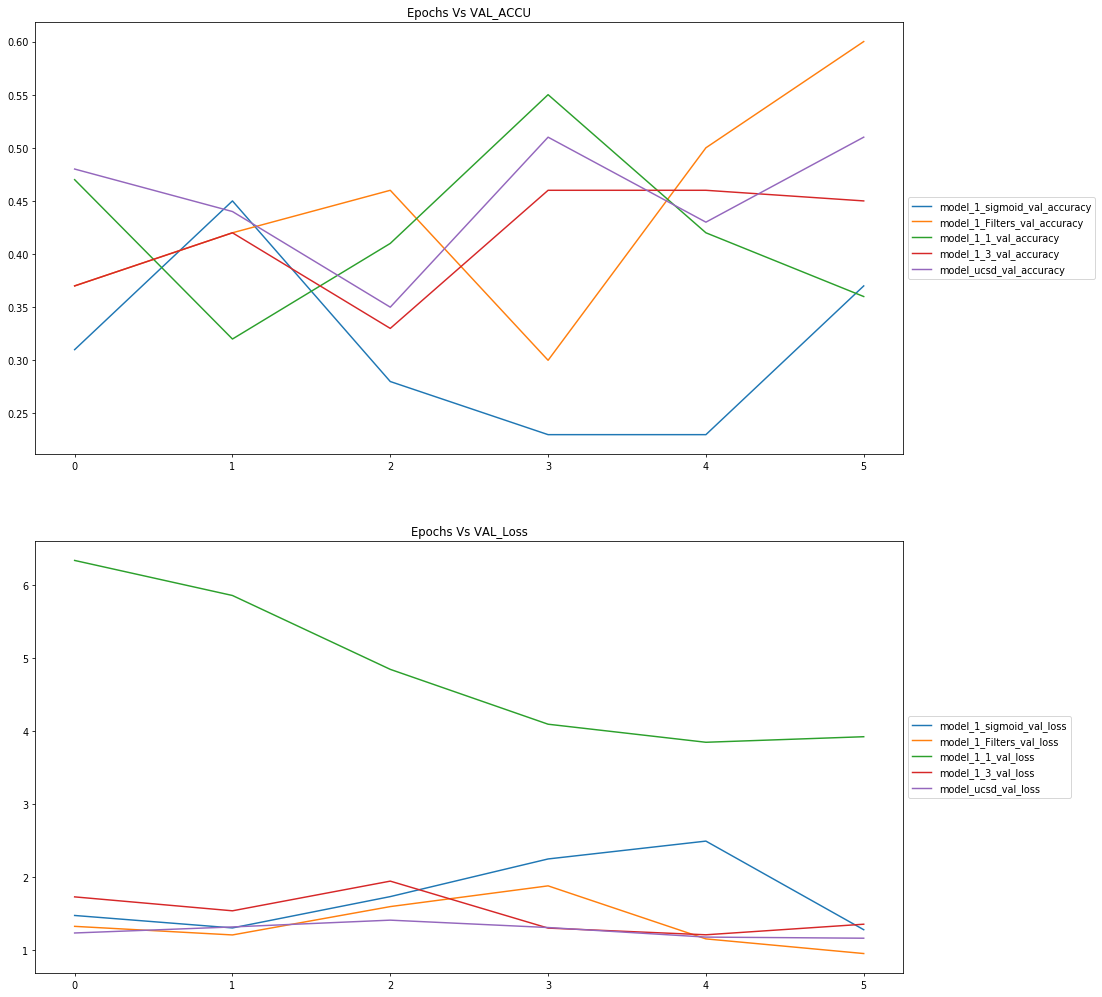

In [60]:
plot_data_collector('Network_Architecture_final.png')

### Observations:
 - From the epochs vs accuracy curve, the top 3 best performing models are - model_1_Filters (Orange) ,model_ucsd (purple) and model_1_3(red)
 - From the epochs vs loss, it is evident that the model with bottle neck layers( red line - model_1_3) has constant accuracy from epochs 3 till 5 indicating that the model could not learn or hit a potential plateau.
 - The ucsd model(purple) has gradual decrease in loss and also, there are very minimal fluctuations in loss.
 - The ucsd model has very less kernal sizes enabling the model to learn variations( more abstract features) from the images.
 - The orange line - Model_1_Filters has higher filters and thus, the model might not perform well when more abstract features are to be extracted ( For example, in the case of poor image quality , the model with higher kernal size, might not be able to extract the maximum abstract features and therefore, it can render poor results).
Therefore, the model ucds will be selected for further processing.


### Image Index 

### Note:
 - Each of the video has 30 images (30 frames)
 - This experimentation is to understand if all the images are required for efficient learning or if we can reduce the number of images.

In [61]:
# Initialise the dataframe
init_data_collector()

In [62]:
img_idx_list=range(ini_frame,num_frames+ini_frame,2)

size_of_batch=10
num_epochs=6
crop=False
normalize=True
edgdetect=[False,2]
affn=True
persp=True
flip=True
train=True

model_name='images_alternate'

model=model_ucsd()
model=optimisation(model,optimise='adam',decay=False,summary=False,lr_rate=best_lr)
train_func(size_of_batch,model,model_name,num_epochs,crop,normalize,edgdetect,train,affn,persp,flip)

Model optimiser is : ADAM
Optimiser Decay is : False
Running with Learning Rate : False
Source path =  ./Project_data/val ; batch size = 10
Image Preprocessing options:  
Cropping :  False
Normalize:  True
Edge Detection :  [False, 2]
Affine Transformation:  False
Mode :  False
Perspective Transformation :  False
Flip Transformation :  False
Single Channel :  False
----------------------------------------
Source path =  ./Project_data/train ; batch size = 10
Image Preprocessing options:  
Cropping :  False
Normalize:  True
Edge Detection :  [False, 2]
Affine Transformation:  True
Mode :  True
Epoch 1/6
Perspective Transformation :  True
Flip Transformation :  True
Single Channel :  False
----------------------------------------
67/67 [==============================] - 107s 2s/step - loss: 1.8588 - categorical_accuracy: 0.2562 - val_loss: 1.3626 - val_categorical_accuracy: 0.4400
Epoch 2/6
67/67 [==============================] - 33s 498ms/step - loss: 1.5371 - categorical_accuracy: 0.3

In [63]:
img_idx_list=range(4,27,1)

size_of_batch=10
num_epochs=6
crop=False
normalize=True
edgdetect=[False,2]
affn=True
persp=True
flip=True
train=True

model_name='images_mid_3_27'

model=model_ucsd()
model=optimisation(model,optimise='adam',decay=False,summary=False,lr_rate=best_lr)
train_func(size_of_batch,model,model_name,num_epochs,crop,normalize,edgdetect,train,affn,persp,flip)

Model optimiser is : ADAM
Optimiser Decay is : False
Running with Learning Rate : False
Source path =  ./Project_data/val ; batch size = 10
Image Preprocessing options:  
Cropping :  False
Source path =  ./Project_data/train ; batch size = 10
Image Preprocessing options:  
Cropping :  False
Normalize:  True
Edge Detection :  [False, 2]
Affine Transformation:  True
Mode :  True
Perspective Transformation :  True
Flip Transformation :  True
Single Channel :  False
----------------------------------------
Epoch 1/6Normalize:  True
Edge Detection :  [False, 2]
Affine Transformation: 
 False
Mode :  False
Perspective Transformation :  False
Flip Transformation :  False
Single Channel :  False
----------------------------------------
67/67 [==============================] - 127s 2s/step - loss: 1.7384 - categorical_accuracy: 0.3015 - val_loss: 1.2308 - val_categorical_accuracy: 0.5500
Epoch 2/6
67/67 [==============================] - 34s 511ms/step - loss: 1.4724 - categorical_accuracy: 0.3

In [64]:
img_idx_list=range(3,26,1)

size_of_batch=10
num_epochs=6
crop=False
normalize=True
edgdetect=[False,2]
affn=True
persp=True
flip=True
train=True

model_name='images_mid_4_27'

model=model_ucsd()
model=optimisation(model,optimise='adam',decay=False,summary=False,lr_rate=best_lr)
train_func(size_of_batch,model,model_name,num_epochs,crop,normalize,edgdetect,train,affn,persp,flip)

Model optimiser is : ADAM
Optimiser Decay is : False
Running with Learning Rate : False
Source path =  ./Project_data/val ; batch size = 10
Image Preprocessing options:  
Cropping :  False
Normalize:  True
Edge Detection :  [False, 2]
Affine Transformation:  False
Mode :  False
Perspective Transformation :  False
Flip Transformation :  False
Single Channel :  False
----------------------------------------
Source path =  ./Project_data/train ; batch size = 10
Epoch 1/6
Image Preprocessing options:  
Cropping :  False
Normalize:  True
Edge Detection :  [False, 2]
Affine Transformation:  True
Mode :  True
Perspective Transformation :  True
Flip Transformation :  True
Single Channel :  False
----------------------------------------
67/67 [==============================] - 128s 2s/step - loss: 1.7740 - categorical_accuracy: 0.2615 - val_loss: 1.4475 - val_categorical_accuracy: 0.2900
Epoch 2/6
67/67 [==============================] - 34s 508ms/step - loss: 1.4492 - categorical_accuracy: 0.3

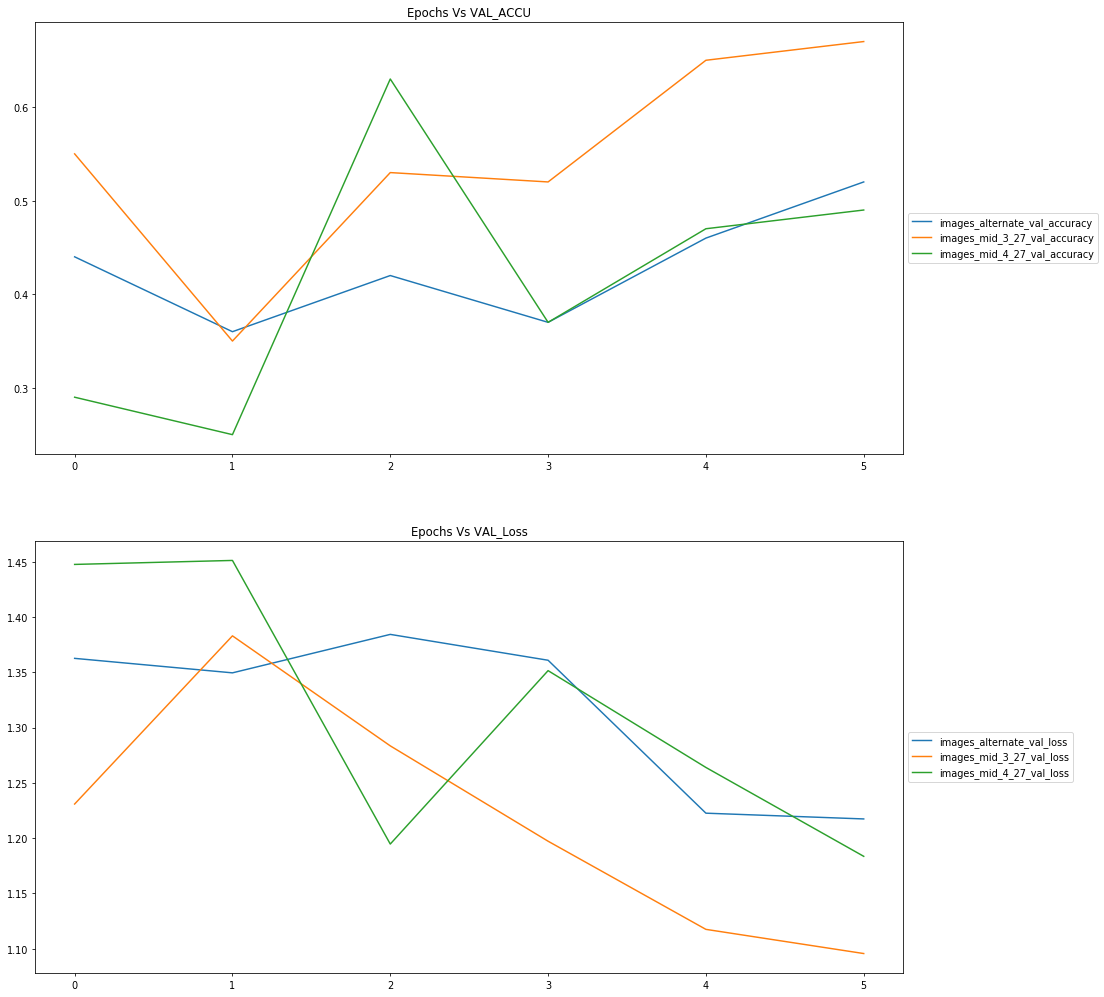

In [65]:
plot_data_collector('index_selection.png')

### Observations:
 - From the accuracy and loss curves,it is evident that first 3 and last 3 images can be ignored. 
 - Thus out of 30 images, 24 images can be used for processing. 

### Channel Selection

### Note:
 - The RGB source images have 3 channels. This experiment is being conducted if the accuracy and loss can be acheived with reduction in the channels.
 - Please note that there could not be reduction in training time/resource consumption. 
 - This is because , the tensor size (input_shape) of CONV3D according to keras depends on the number of channels. In this projet, the images are 120x160x3 (or 120x120x3). When they are converted to greyscale, the image size will be 120x120 ( not 120x120x1). Thus CONV3D tensor will not accept this shape (channel number missing). 
 - Inorder to experiment the number of channels, the Green and Blue channel of the image has been set to 0. Therefore, the iamge size and thus the tensor size will not change.

In [71]:
# Initialise the dataframe
init_data_collector()

In [72]:
img_idx_list=range(3,27,1)
size_of_batch=10
num_epochs=10
crop=False
normalize=True
edgdetect=[False,2]
affn=True
persp=True
flip=True
train=True
best_lr=0.002
Singchannel=False

model_name='RGB_Channel'

model=model_ucsd()
model=optimisation(model,optimise='adam',decay=False,summary=True,lr_rate=best_lr)
train_func(size_of_batch,model,model_name,num_epochs,crop,normalize,edgdetect,train,affn,persp,flip,Singchannel)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_78 (Conv3D)           (None, 30, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_77 (Batc (None, 30, 120, 120, 8)   32        
_________________________________________________________________
max_pooling3d_73 (MaxPooling (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_79 (Conv3D)           (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
batch_normalization_78 (Batc (None, 15, 60, 60, 16)    64        
_________________________________________________________________
max_pooling3d_74 (MaxPooling (None, 7, 30, 30, 16)     0         
_________________________________________________________________
conv3d_80 (Conv3D)           (None, 7, 30, 30, 32)     4640      
__________

In [73]:
img_idx_list=range(3,27,1)
size_of_batch=10
num_epochs=10
crop=False
normalize=True
edgdetect=[False,2]
affn=True
persp=True
flip=True
train=True
best_lr=0.002
Singchannel=True

model_name='Single_Channel'

model=model_ucsd()
model=optimisation(model,optimise='adam',decay=False,summary=True,lr_rate=best_lr)
train_func(size_of_batch,model,model_name,num_epochs,crop,normalize,edgdetect,train,affn,persp,flip,Singchannel)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_83 (Conv3D)           (None, 30, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_80 (Batc (None, 30, 120, 120, 8)   32        
_________________________________________________________________
max_pooling3d_77 (MaxPooling (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_84 (Conv3D)           (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
batch_normalization_81 (Batc (None, 15, 60, 60, 16)    64        
_________________________________________________________________
max_pooling3d_78 (MaxPooling (None, 7, 30, 30, 16)     0         
_________________________________________________________________
conv3d_85 (Conv3D)           (None, 7, 30, 30, 32)     4640      
__________

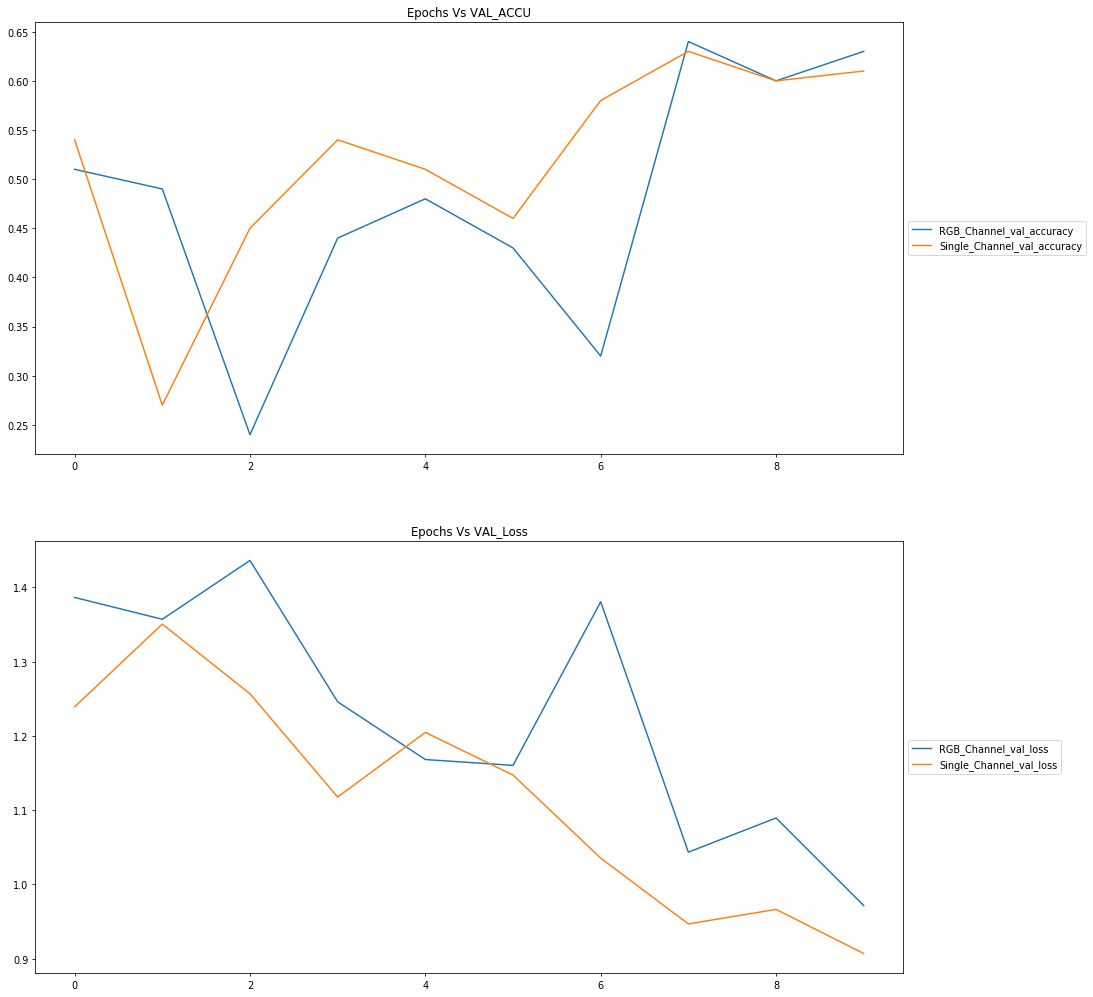

In [74]:
plot_data_collector('Channels_Selected.png')

### Observations:
 - From the epochs vs accuracy/loss, it is evident that better reduction of loss can be acheived with single channel image.
 - The Data Generator function and CONV3D model can be redefined to use single channel image (or a gray scale) image. This greately reduces the training time and will be resource economical.
 - Keeping in view the timelines for this project, this experimentation is not being covered.

## Segment : 5 - Run the Final Model and store the H5 file

In [19]:
# Initialise the dataframe
init_data_collector()

In [20]:
# Define call back to capture the model
curr_dt_time = datetime.datetime.now()
model_name = 'model_CON3D' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
model_store='./'+model_name
if not os.path.exists(model_name):
    os.mkdir(model_store)
        
filepath = model_store + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)


callbacks_list=[LR,checkpoint]

In [21]:
img_idx_list=range(3,27,1)
size_of_batch=10
num_epochs=50
crop=False
normalize=True
edgdetect=[False,2]
affn=True
persp=True
flip=True
train=True
best_lr=0.003
Singchannel=False

model_name='model_final'

model=model_ucsd()
model=optimisation(model,optimise='adam',decay=False,summary=True,lr_rate=best_lr)
train_func(size_of_batch,model,model_name,num_epochs,crop,normalize,edgdetect,train,affn,persp,flip,Singchannel)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 120, 120, 8)   32        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 60, 60, 16)    64        
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 7, 30, 30, 16)     0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 7, 30, 30, 32)     4640      
__________

67/67 [==============================] - 40s 594ms/step - loss: 0.8853 - categorical_accuracy: 0.6082 - val_loss: 0.7890 - val_categorical_accuracy: 0.7400

Epoch 00017: saving model to ./model_CON3D_2019-07-0100_08_32.388154/model-00017-0.88529-0.60821-0.78903-0.74000.h5
Epoch 18/50
67/67 [==============================] - 39s 589ms/step - loss: 0.8020 - categorical_accuracy: 0.6343 - val_loss: 0.7415 - val_categorical_accuracy: 0.7200

Epoch 00018: saving model to ./model_CON3D_2019-07-0100_08_32.388154/model-00018-0.80199-0.63433-0.74145-0.72000.h5
Epoch 19/50
67/67 [==============================] - 38s 572ms/step - loss: 0.9252 - categorical_accuracy: 0.6144 - val_loss: 0.7251 - val_categorical_accuracy: 0.7400

Epoch 00019: saving model to ./model_CON3D_2019-07-0100_08_32.388154/model-00019-0.92518-0.61443-0.72507-0.74000.h5
Epoch 20/50
67/67 [==============================] - 37s 559ms/step - loss: 0.7731 - categorical_accuracy: 0.6816 - val_loss: 0.7397 - val_categorical_accura

67/67 [==============================] - 38s 566ms/step - loss: 0.4768 - categorical_accuracy: 0.8072 - val_loss: 0.5540 - val_categorical_accuracy: 0.7900

Epoch 00044: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.

Epoch 00044: saving model to ./model_CON3D_2019-07-0100_08_32.388154/model-00044-0.47680-0.80721-0.55405-0.79000.h5
Epoch 45/50
67/67 [==============================] - 38s 565ms/step - loss: 0.4476 - categorical_accuracy: 0.8259 - val_loss: 0.5533 - val_categorical_accuracy: 0.7900

Epoch 00045: saving model to ./model_CON3D_2019-07-0100_08_32.388154/model-00045-0.44760-0.82587-0.55327-0.79000.h5
Epoch 46/50
67/67 [==============================] - 38s 569ms/step - loss: 0.4582 - categorical_accuracy: 0.8209 - val_loss: 0.5527 - val_categorical_accuracy: 0.7900

Epoch 00046: ReduceLROnPlateau reducing learning rate to 4.882812731921149e-07.

Epoch 00046: saving model to ./model_CON3D_2019-07-0100_08_32.388154/model-00046-0.45816-0.82090-0.55272-0.7900

### Conclusion :
 - To avoid any information loss, all the images have been considered for model training
 - The number of epochs have been increased drastically to geenralise the model training
 - Batch Size of 10 ( x4 = 40) has been considered for the batch run. Batch run above this value will lead to Runtime errors due to resource constraints

Based on above considerations, the model that has training accuracy of 0.7376 and validation accuracy of 0.84 will be selected.

NOTE: There is a small drop in the training accuracy compared to Validation accuracy and this is due to the Batch Normalisation and DropOuts added with in model
    